#### import

In [7]:
import pandas as pd
import numpy as np
import json
import os
from os.path import join
import tqdm
import time
import pickle as pkl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

UNK, PAD, SEP = '<UNK>', '<PAD>', '<SEP>'  # 未知字，padding符号

home_path = os.path.expanduser('~')

### data_process

In [14]:
def join(path):
    '''
    hide the home path
    '''
    home_path = os.path.expanduser('~')
    path = os.path.join(home_path, path)
    return path

In [16]:
data_dir = join(r'data/snli_1.0')
data_path = os.path.join(data_dir, 'snli_1.0_train.jsonl')
df = pd.read_json(data_path, lines=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550152 entries, 0 to 550151
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   annotator_labels        550152 non-null  object
 1   captionID               550152 non-null  object
 2   gold_label              550152 non-null  object
 3   pairID                  550152 non-null  object
 4   sentence1               550152 non-null  object
 5   sentence1_binary_parse  550152 non-null  object
 6   sentence1_parse         550152 non-null  object
 7   sentence2               550152 non-null  object
 8   sentence2_binary_parse  550152 non-null  object
 9   sentence2_parse         550152 non-null  object
dtypes: object(10)
memory usage: 42.0+ MB


In [18]:
df.drop(df.loc[df['gold_label']=='-'].index).shape

(549367, 10)

In [20]:
df['gold_label'].value_counts()
df = df.loc[df['gold_label'] != '-']
df['gold_label'].value_counts()

entailment       183416
contradiction    183187
neutral          182764
Name: gold_label, dtype: int64

In [22]:
df['sen1_len'] = df['sentence1'].apply(lambda x: len(x.split(' ')))
df['sen2_len'] = df['sentence2'].apply(lambda x: len(x.split(' ')))

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='sen1_len', data=df)
plt.xticks([])
plt.show()

sns.countplot(x='sen2_len', data=df)
plt.xticks([])
plt.show()

ModuleNotFoundError: No module named 'seaborn'

<AxesSubplot:xlabel='sen1_len', ylabel='Count'>

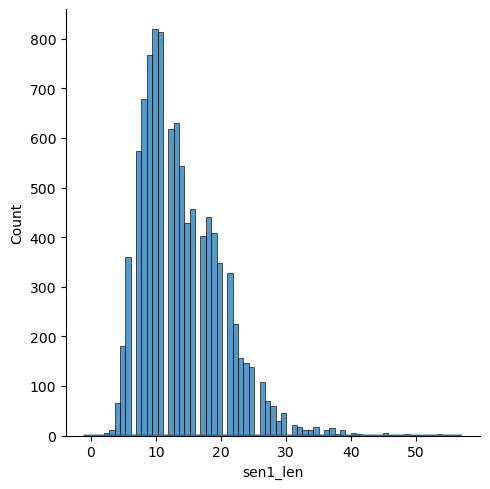

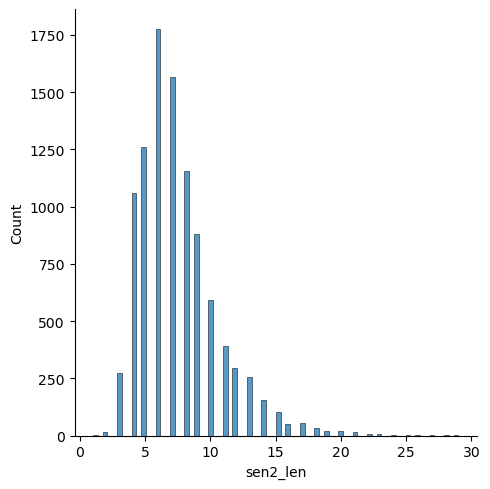

In [312]:
sns.displot(df['sen1_len']) # plt.hist and sns.kdeplot
sns.kdeplot(df['sen1_len'])
plt.show()

sns.displot(df['sen2_len']) # plt.hist and sns.kdeplot
plt.show()

#### build label_map

In [13]:
labels = df['gold_label'].unique().tolist()
label_map = dict.fromkeys(labels, None)
label_map
for i, label in enumerate(labels):
    label_map.update({label:i})
label_map
pkl.dump(label_map, open(os.path.join(data_dir, 'label_map.pkl'), 'wb'))

NameError: name 'df' is not defined

#### glove process

In [210]:
glove_path = join(r'pretrained_models/glove/standford/glove.6B.200d.txt')
with open(glove_path, 'r', encoding='utf-8') as f:
    vocab_map = {}
    data = list()
    for i,line in enumerate(f.readlines()):
        w2vlist = line.split()
        word, vector = w2vlist[0], w2vlist[1:]
        vocab_map[word] = i
        data.append(vector)
    data.append([0]*len(data[0]))
    data.append([0]*len(data[0]))
    data.append([0]*len(data[0]))
    vocab_map.update({UNK: len(vocab_map), SEP:len(vocab_map)+1, PAD: len(vocab_map) + 2})
    data = np.array(data, float)
pkl.dump(vocab_map, open(join(r'pretrained_models/glove/standford/vocab_map.pkl'), 'wb'))
pkl.dump(data, open(join(r'pretrained_models/glove/standford/glove.6B.200d.pkl'), 'wb'))

### utils

#### Config

In [10]:
class Config(object):
    def __init__(self, embed_path=None, vocab_path=None):
        
        # pararms for dataset
        self.train_path = join(r'data/snli_1.0/snli_1.0_train.jsonl')
        self.dev_path = join(r'data/snli_1.0/snli_1.0_dev.jsonl')
        self.test_path = join(r'data/snli_1.0/snli_1.0_test.jsonl')
        
        # for self-build dataset
#         self.train_set_path = r'./data_set/train.pkl'
#         self.dev_set_path = r'./data_set/dev.pkl'
#         self.test_set_path = r'./data_set/test.pkl'

        self.vocab_map = pkl.load(open(vocab_path, 'rb')) if vocab_path else pkl.load(open(join(r'pretrained_models/glove/standford/vocab_map.pkl'), 'rb'))
        self.n_vocab = len(vocab_map)
        self.label_map = pkl.load(open(join(r'data/snli_1.0/label_map.pkl'), 'rb'))
        self.label_num = len(self.label_map)
        
        # params for train
        self.pad_size = 63
        self.batch_size = 32
        self.epoch = 20
        self.learning_rate = 1e-3
        self.drop_out = 0.3
        self.log_step = 1000
        
        
        # params for embedding
        self.embedding_pretrained = torch.FloatTensor(pkl.load(open(embed_path, 'rb'))) if embed_path is not None else None
        self.embedding_len = self.embedding_pretrained.size(1) if self.embedding_pretrained is not None else 300
        
        # params for rnn model
        self.rnn_hidden = 128
        self.rnn_layer = 2
        self.bi_rnn = False
        
        # params for cnn model
        self.num_channel = 256
        self.kernel_sizes = (3, 4, 5)
        
        # device
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [287]:
config = Config()

In [289]:
config.label_map

{'neutral': 0, 'contradiction': 1, 'entailment': 2}

#### Dataset Iterater

In [9]:
def SNLItokenizer(sentence, pad_size):
    tokenizer = lambda x: x.aplit() # word_level tokenzier
    def pad_and_trunc(tokens):
        if len(tokens) < pad_size:
            tokens.extend([PAD] * (pad_size - len(tokens)))
        else:
            tokens = tokens[:pad_size]
        return tokens
    tokens = tokenizer(sentence)
    tokens = pad_and_trunc(tokens)
    return tokens
    
class SNLIDataset(Dataset):
    
    def __init__(self, hypothesis, premise, labels, config):
        self.hypothesis = hypothesis
        self.premise = premise
        self.labels = labels
        self.pad_size = config.pad_size
        self.device = config.device
        self.vocab_map = config.vocab_map
        self.label_map = config.label_map

    def __getitem__(self, index):
        # padding and truncation
        tokens_p = SNLItokenizer(self.premise[index], self.pad_size)
        tokens_h = SNLItokenizer(self.hypothesis[index], self.pad_size)
#         tokens = SNLItokenizer(self.hypothesis[index], self.target_tensor[index], self.pad_size)
        token_ind = [vocab.get(token, vocab.get(UNK)) for token in tokens]
        ind_p = [vocab.get(token, vocab.get(UNK)) for token in tokens_p]
        ind_h = [vocab.get(token, vocab.get(UNK)) for token in tokens_h]
        p = torch.LongTensor(ind_p).to(self.device)
        h = torch.LongTensor(ind_h).to(self.device)
        y = torch.LongTensor(self.label_map.get(self.labels[index])).to(self.device)
        return p, h , y

    def __len__(self):
        return len(self.labels)

def build_dataset(config):
    def load_dataset(path):
        df = pd.read_json(path, lines=True).drop(df.loc[df['gold_label']=='-'].index, inplace=True)
        return SNLIDataset(df['sentence1'].tolist(), df['sentence2'], df['gold_label'], config)
    train_set = load_dataset(config.train_path)
    dev_set = load_dataset(config.dev_set)
    test_set = load_dataset(config.test_set)
    return train_set, dev_set, test_set
    
# tensor_dataloader = DataLoader(tensor_dataset,     # 封装的对象
#                                batch_size = 2,     # 输出的batch size
#                                shuffle = True,     # 随机输出
#                                num_workers = 0)    # 只有1个进程

In [12]:
config = Config()
train_set, dev_set, test_set = build_dataset(config)

FileNotFoundError: [Errno 2] No such file or directory: '/home2/rzhao/pretrained_models/glove/standford/vocab_map.pkl'

In [11]:
SNLIDataset()

TypeError: __init__() missing 4 required positional arguments: 'hypothesis', 'premise', 'labels', and 'config'

In [119]:
df.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, entailment, neutral, neutral, neutral]",4705552913.jpg#2,neutral,4705552913.jpg#2r1n,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,The sisters are hugging goodbye while holding ...,( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...
1,"[entailment, entailment, entailment, entailmen...",4705552913.jpg#2,entailment,4705552913.jpg#2r1e,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,Two woman are holding packages.,( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...
2,"[contradiction, contradiction, contradiction, ...",4705552913.jpg#2,contradiction,4705552913.jpg#2r1c,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,The men are fighting outside a deli.,( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...
3,"[entailment, entailment, entailment, entailmen...",2407214681.jpg#0,entailment,2407214681.jpg#0r1e,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids in numbered jerseys wash their hands.,( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...
4,"[neutral, neutral, neutral, entailment, entail...",2407214681.jpg#0,neutral,2407214681.jpg#0r1n,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids at a ballgame wash their hands.,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...


### model

#### LSTM with Attention

In [ ]:
class ESIM(nn.Module):
    self.__init__(self):
        super.__init__(ESIM)

#### LSTM with word by word Attention

#### 3.3 ESIM

reference: <br>
https://github.com/coetaur0/ESIM <br>
https://github.com/MrXJC/ESIM<br>
https://github.com/Alic-yuan/nlp-beginner-finish
<img src="esim.png" width="80%"> 

In [ ]:
class ESIM(nn.Module):
    def __init__(self, config):
        super(ESIM, self).__init__():